# Robot Simulator

### Introduction

Sometimes, it is possible to use software simulation to test a robot in virtual environments. Extremely complex simulators that use supercomputing technology can accurately simulate a robot in a physical environment. Sometimes, this is more cheaper and easier than physically testing a robot in a potentially dangerous environment.

### Jupyter Notebooks

You are looking at an interactive Python notebook called a Jupyter Notebook. Code can exist in Markdown cells (like the one you are reading) or in Python cells (like the one below.) You can run a code cell by clicking on it and hitting `Ctrl-Enter` on your keyboard. Try running the cell below.

In [1]:
n = 1
print "The value of n is", n

The value of n is 1


### Re-running Cells

Jupyter runs a Python _kernel_. This kernel allows you to keep any variables or functions in Jupyter's memory until you restart the kernel using the menu above. (You can click on `Kernel` in the menu bar and then `Restart`, or click the button in the toolbar that looks like a reset button.) This also allows you to run cells in any order, multiple times. Try running the cell below a few times, then restarting the kernel.

In [2]:
n = n + 1
print "The value of n is now", n

The value of n is now 2


### Did you get an error?

You may have gotten an error that says `"name 'n' is not defined"` if you tried to restart the kernel and run the cell above. That's because the variable was defined in the first cell, and when you restarted the kernel the variable was lost. Try restarting the kernel, running the first code cell, then running the above cell again.

### Simulation Code

The code cell below is a pre-written simulation framework. Don't worry if you don't understand this code -- you don't have to! Programmers frequently use open source code without the need to completely understand how it works. They only need to know how to use it. You may recall that this concept is called _black box_ programming.

This framework will allow you to easily write logic for a robot that can drive forward, stop, wait, and take a distance reading to the nearest obstacle using an Ultrasonic Range Finder. In the simulation, the robot is driving towards a wall while continuously taking sensor readings. You can simulate how the robot will act, and the simulator will return time, position and sensor reading data from the simulation. First run the cell below. You should get a message below it that says `Simulation tools loaded.`

In [3]:
import numpy as np
from multiprocessing import Process, Manager
from multiprocessing.managers import BaseManager
import time

import matplotlib.image as mpimg
import urllib2
f = urllib2.urlopen("https://github.com/jchuahtacc/RobotSim/raw/master/test.png")
img_file = mpimg.imread(f)

wall_position = 100
timelimit = 3000

class Robot:
    timelimit = 3000
    wall_position = 100
    timesteps = [ ]
    distance_readings = [ ]
    positions = [ ]
    speed = 0
    sensor_error = 5
    speed_error = 0.02
    drive_speed = 0.05
    

    def reset(self):
        global wall_position
        global timelimit
        self.timelimit = timelimit
        self.wall_position = wall_position
        
        self.timesteps = [ 1 ]
        self.positions = [ 0 ]
        self.distance_readings = [ self._generate_reading() ]
        
    def _generate_reading(self):
        return self.wall_position - self.positions[-1] + np.random.random() * self.sensor_error - self.sensor_error / 2

    def _generate_position(self):
        if self.speed > 0:
            return self.positions[-1] + self.speed + np.random.random() * self.speed_error - self.speed_error / 2
        else:
            return self.positions[-1]
    
    def timeout(self):
        return self.timesteps[-1] > self.timelimit
    
    def tick(self):
        self.timesteps.append(self.timesteps[-1] + 1)
        self.positions.append(self._generate_position())
        self.distance_readings.append(self._generate_reading())

    def drive(self):
        self.speed = self.drive_speed
        self.tick()

    def stop(self):
        self.speed = 0
        self.tick()

    def wait(self, steps):
        for i in range(steps):
            self.tick()

    def read_sensor(self):
        self.tick()
        return self.distance_readings[-1]
    
    def getResults(self):
        return (self.timesteps[:self.timelimit], self.positions[:self.timelimit], self.distance_readings[:self.timelimit])

    def __init__(self):
        self.reset()

def _run(robot_loop, robot):
    while not robot.timeout():
        robot_loop(robot)
        robot.tick()

def simulate(robot_loop):
    BaseManager.register('Robot', Robot)
    manager = BaseManager()
    manager.start()
    robot = manager.Robot()
    robot.reset()

    print "Running simulator..."
    runner = Process(target=_run, args=(robot_loop, robot))
    runner.start()
    print "Waiting"
    time.sleep(1)
    print "Ending simulator..."
    runner.terminate()
    runner.join()
    print "Simulator finished."
    return robot.getResults()

def summarize(steps, positions, readings):
    print ""
    print "*** Simulation Results ***"
    print "Simulated time (ms):", len(steps)
    print "Position readings:", len(positions)
    print "Sensor readings:", len(readings)
    print "Final robot distance from the wall:", wall_position - positions[-1], "cm"
    if wall_position - positions[-1] > 0:
        print "Robot did not impact wall :)"
    else:
        print "Robot impacted wall :("
    print ""

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def visualize(steps, positions, readings):
    max_reading = max(readings)
    min_reading = min(readings)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    ax1.set_xlim(0, len(steps))
    ax1.set_ylim(0, max_reading)
    ax1.set_xlabel("time (milliseconds)")
    ax1.set_ylabel("distance reading (centimeters)")
    ax2.set_xlim(-10, 110)
    ax2.set_ylim(0, 20)
    ax2.set_xlabel("simulation (centimeters)")


    readings_graph, = ax1.plot(steps[:1], readings[:1])
    img = ax2.imshow(img_file, animated=True)

    def animate(i):
        readings_graph.set_data(steps[:i+1], readings[:i+1])
        if i < len(positions):
            img.set_extent((positions[i] - 10, positions[i] + 10, 0, 20))
        return readings_graph, img

    interval = 50

    print "Generating animation..."

    anim = FuncAnimation(fig, animate, frames=range(0, len(steps) + interval , interval), interval=interval,blit=True)
    return anim.to_html5_video()

print "Simulation tools loaded."


Simulation tools loaded.


### Robot Logic

Many robot microcontrollers use a _sketch_ style programming model, with a function called `_loop_` that is called over and over. Below is an example loop function. Run the code cell below to create the `example_robot_loop` function. Later on, you will create your own logic function for the simulation.

In [4]:
def example_robot_loop(robot):
    robot.drive()
    robot.wait(250)
    robot.stop()
    robot.wait(500)
    
print "example_robot_loop function created"

example_robot_loop function created


### Run the Simulator

Great! Now that we have some logic, we should run it through the simulator. This will give us some data.

In [5]:
(steps, positions, readings) = simulate(example_robot_loop)

summarize(steps, positions, readings)

Running simulator...
Waiting
Ending simulator...
Simulator finished.

*** Simulation Results ***
Simulated time (ms): 3000
Position readings: 3000
Sensor readings: 3000
Final robot distance from the wall: 49.959266922 cm
Robot did not impact wall :)



### Visualizing the Data

Simulations like the one we are using return raw data. In this case, the `simulate` function ran `example_robot_loop` and generated several lists of data - `steps`, `positions`, and `readings`. This can be useful for engineers or data scientists, but it is less useful if you just want to know what happened during the simulation. _Visualizations_ are helpful for this purpose. The code cell below visualizes your simulation data as a movie showing the Ultrasonic Range Finder readings and an animation of the robot. See if you can correlate what was happening in `example_robot_loop` to what you see in the simulation.

Generating animation...


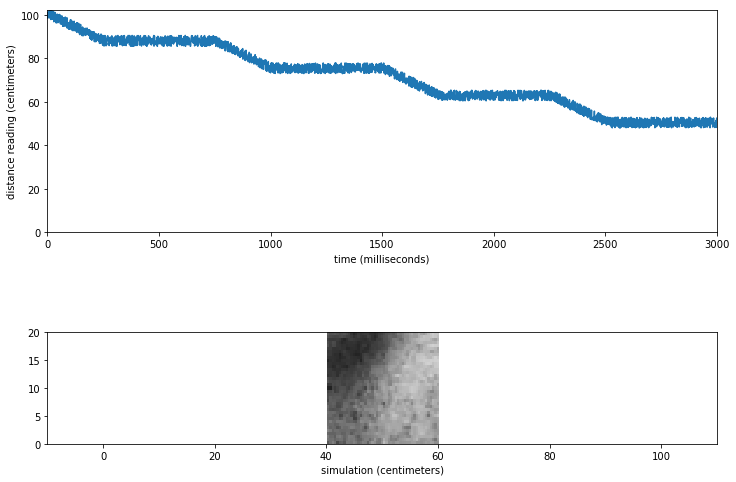

In [6]:
HTML(visualize(steps, positions, readings))

### Noisy Data!

Notice that the distance readings are a little "jittery." Many sensors exhibit some inaccuracy, depending on their precision. Even when the robot is not moving, the jitter in the range finder shows inconsistent values. The motor operation even exhibits a little bit of jitter, meaning the robot may not move the exact same distance each time it drives for a specified amount of time. Due to both of these factors, the distance reading almost never returns the _true_ distance to the wall, just an approximate reading.

### Now Your Turn!

Ideally, we want the robot to drive forward and stop before it hits the wall, which is approximately 100 centimeters away from it's starting position. Below is a robot loop that doesn't quite get the job done. See if you can modify the code inside `stop_before_wall_loop` to make it function correctly. Don't worry if you aren't a Python export! Make small changes to the existing code and re-run the cell until you get a simulation result you are happy with!

Running simulator...
Waiting
Ending simulator...
Simulator finished.

*** Simulation Results ***
Simulated time (ms): 3000
Position readings: 3000
Sensor readings: 3000
Final robot distance from the wall: -50.3179538758 cm
Robot impacted wall :(

Generating animation...


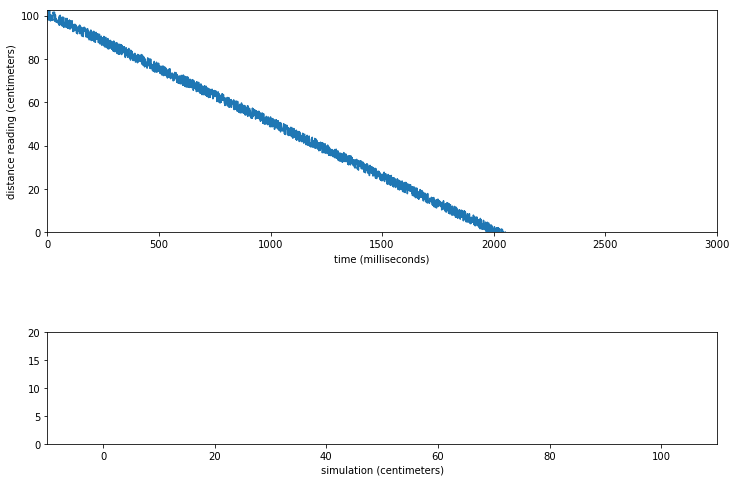

In [7]:
def stop_before_wall_loop(robot):
    if robot.read_sensor() == 0:
        robot.stop()
    else:
        robot.drive()
        robot.wait(10)

(steps, positions, readings) = simulate(stop_before_wall_loop)
summarize(steps, positions, readings)
HTML(visualize(steps, positions, readings))